## ABOUT

- tried resnet18, worse then resnet34
- tried resnet34, big custom head, only unfrozen training: got to mae 2.12
- tried resnet34, small custom head, only unfrozen training: got to mae 2.37
- tried resnet34, bigger custom head: got to mae 2.14

- still experimenting in this notebook

---
- Best MAE:
- LB Score:

## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.50.post1
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [5]:
version = 'v12'       # this should match the notebook filename

arch = models.resnet34
use_custom_model = False   # set to True to override pre-trained model

size = (128, 384)
bs = 32
num_workers = 8     # set to available cores

scale = 1           # number to divide y by to help normalize values
transform = 'mel'  # which time series to visual transformation to use

## DATA

Assumes the following has been generated using `gen_spectrogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
# set paths
path = pathlib.Path.home()/'.fastai/data/kaggle_earthquake'
img_path = path/f'train_images/{transform}'
save_path = path/'saved_models'
os.makedirs(save_path, exist_ok=True)

In [7]:
# load segment CSVs
#pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [8]:
#X_train.head()

In [9]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


min: 0.0063976571678
max: 16.103195567


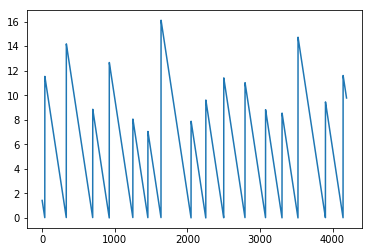

In [10]:
# graph y_train
print('min:', min(y_train['time_to_failure']))
print('max:', max(y_train['time_to_failure']))
plt.plot(y_train)

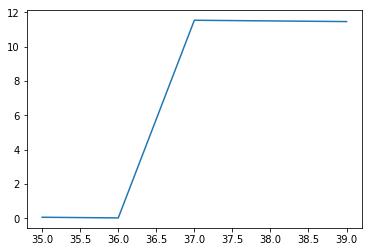

In [11]:
# find a segment with an earthquake
plt.plot(y_train[35:40])

In [12]:
y_train[35:40]

,time_to_failure
35,0.066798
36,0.028496
37,11.530097
38,11.490799
39,11.452496


## MODEL

In [13]:
# scale down the labels
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return ttf / scale

In [14]:
# unscaled is 1.4307971859
gen_label(img_path/'seg_0.png')

1.4307971859

In [15]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [16]:
fake_label = 0.
#valid_idx = range(3000, len(y_train))

src = (ImageList.from_folder(img_path)
        .split_by_rand_pct(valid_pct=0.30)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder(f'../../test_images/{transform}', label=fake_label))

In [17]:
# custom model
if use_custom_model == True:
    data = (src.transform(tfms, resize_method=ResizeMethod.NO, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize())
# pre-trained model
else:
    data = (src.transform(tfms, resize_method=ResizeMethod.NO, size=size)
            .databunch(bs=bs, num_workers=num_workers)
            .normalize(imagenet_stats))

In [18]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  2936
valid:  1258
test:   2624

TOTAL:  6818


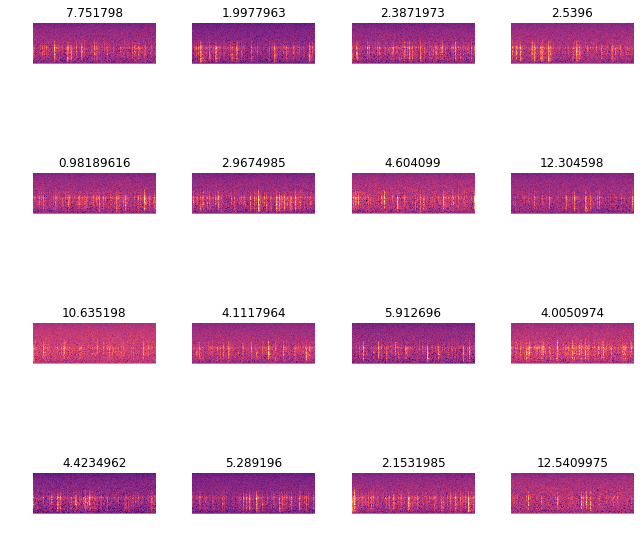

In [19]:
# verify images and labels match up
data.show_batch(4, figsize=(9, 9))

In [20]:
# define metrics
def mae_scaled(preds, targs):
    return mean_absolute_error(preds.view(-1)*scale, targs.view(-1)*scale)

def mse_scaled(preds, targs):
    return mean_squared_error(preds.view(-1)*scale, targs.view(-1)*scale)

In [21]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds.view(-1), targs.view(-1))

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds.view(-1), targs.view(-1))

In [22]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet50 and size == 224: return 2048*7*7
    elif arch == models.resnet50 and size == 384: return 2048*12*12
    elif arch == models.resnet50 and size == (128,384): return 2048*4*12
    elif arch == models.resnet34 and size == (128,384): return 512*4*12
    elif arch == models.resnet18 and size == (128,384): return 512*4*12

In [53]:
# helper functions for custom models

def linear_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Dropout(0.5),
        nn.Linear(in_channels, out_channels),
        nn.ReLU())

# no activation
def final_block(in_channels, out_channels):
    return nn.Sequential(
        nn.BatchNorm1d(in_channels),
        nn.Dropout(0.5),
        nn.Linear(in_channels, out_channels))

def conv1d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=10, stride=10),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())

def conv2d_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU())

def five_conv2d_blocks(c):
    return nn.Sequential(
        conv2d_block(3, c),
        conv2d_block(c, c*2),
        conv2d_block(c*2, c*4),
        conv2d_block(c*4, c*8),
        conv2d_block(c*8, c*16))

In [54]:
# custom heads
small_head = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

small_head_sigmoid = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1),  nn.Sigmoid())

medium_head = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(),
  linear_block(2048, 256),
  final_block(256, 1))

big_head = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(),
  linear_block(2048, 512),
  linear_block(512, 128),
  final_block(128, 1))

big_head_sigmoid = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(),
  linear_block(2048, 512),
  linear_block(512, 128),
  final_block(128, 1),
  nn.Sigmoid())

big_head34 = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(),
  linear_block(512, 128),
  linear_block(128, 16),
  final_block(16, 1))

bigger_head34 = nn.Sequential(
  nn.AvgPool2d((4, 12)),
  Flatten(),
  linear_block(512, 256),
  linear_block(256, 128),
  linear_block(128, 64),
  linear_block(64, 32),
  linear_block(32, 16),
  linear_block(16, 8),
  final_block(8, 1))

In [56]:
# custom models
conv1d_model = nn.Sequential(
    conv1d_block(1, 8),
    conv1d_block(8, 16),
    conv1d_block(16, 32),
    Flatten(),
    #nn.AvgPool?
    linear_block(150, 16),
    final_block(16, 1))

start_channels = 32
end_channels = start_channels * 16

conv2d_model = nn.Sequential(
    five_conv2d_blocks(start_channels),
    nn.AvgPool2d((4, 12)),
    Flatten(),
    linear_block(end_channels, 32),
    final_block(32, 1))

In [75]:
# custom model
if use_custom_model == True:
    learn = Learner(data, conv2d_model,
                        loss_func=l1_loss,
                        metrics=[mean_squared_error, mean_absolute_error, mse_scaled, mae_scaled])
# pre-trained model
else:
    learn = cnn_learner(data, arch,
                        custom_head=bigger_head34,
                        loss_func=l1_loss,
                        metrics=[mean_squared_error, mean_absolute_error, mse_scaled, mae_scaled])

In [76]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 192]        9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 192]        128        True      
______________________________________________________________________
ReLU                 [64, 64, 192]        0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 96]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 96]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 96]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 96]         0          False     
______________________________________________________________

## TRAIN

#### Helper functions

In [77]:
def plot_lr_find(learn):
    learn.lr_find()
    learn.recorder.plot()

In [78]:
def fit_one_cycle(learn, stage, n_epochs, max_lr):
    learn.fit_one_cycle(n_epochs, max_lr=max_lr, callbacks=[
        SaveModelCallback(learn,
                          monitor='mean_absolute_error',
                          mode='min',
                          every='improvement',
                          name=save_path/f'{version}-{stage}-best')])
    learn.recorder.plot_losses()
    learn.recorder.plot_lr(show_moms=True)

#### Stage 1.1

In [79]:
if use_custom_model == False:
    learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


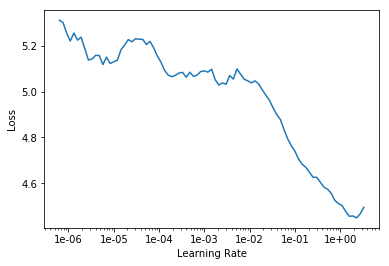

In [80]:
plot_lr_find(learn)

In [81]:
stage = 's1.1'
n_epochs = 7
max_lr = slice(3e-2)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,4.176009,2.992157,13.397492,2.992157,13.397492,2.992157,00:07
1,3.299573,2.426415,10.167722,2.426415,10.167722,2.426415,00:07
2,2.824929,2.350844,8.335165,2.350844,8.335165,2.350844,00:07
3,2.654443,2.270870,8.531612,2.270871,8.531612,2.270871,00:07
4,2.550842,2.257182,8.126513,2.257182,8.126513,2.257182,00:07
5,2.484393,2.270064,8.696894,2.270065,8.696894,2.270065,00:07
6,2.457252,2.224708,8.167744,2.224708,8.167744,2.224708,00:07


Better model found at epoch 0 with mean_absolute_error value: 2.992156744003296.
Better model found at epoch 1 with mean_absolute_error value: 2.426414966583252.
Better model found at epoch 2 with mean_absolute_error value: 2.350843667984009.
Better model found at epoch 3 with mean_absolute_error value: 2.2708709239959717.
Better model found at epoch 4 with mean_absolute_error value: 2.2571823596954346.
Better model found at epoch 6 with mean_absolute_error value: 2.224707841873169.


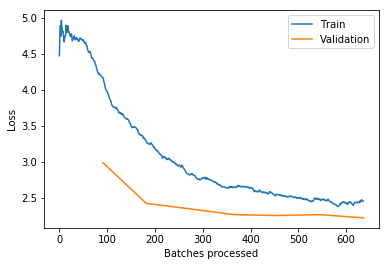

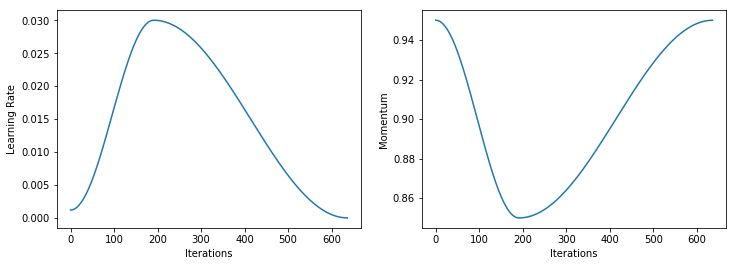

In [82]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 1.2

In [65]:
learn.load(save_path/f'{version}-s1.1-best');

In [66]:
if use_custom_model == False:
    learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


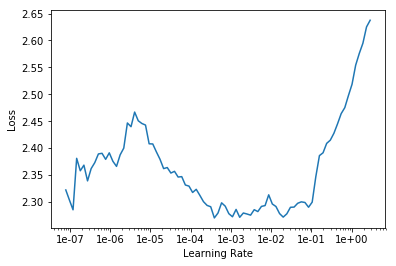

In [67]:
learn.lr_find(start_lr=1e-8)
learn.recorder.plot()

In [68]:
stage = 's1.2'
n_epochs = 10
max_lr = slice(1e-4)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,2.334142,2.172730,7.880609,2.172731,7.880609,2.172731,00:07
1,2.338331,2.152946,7.608940,2.152946,7.608940,2.152946,00:07
2,2.308919,2.157176,7.614450,2.157176,7.614450,2.157176,00:07
3,2.282210,2.146945,7.525651,2.146945,7.525651,2.146945,00:07
4,2.321890,2.149943,7.655159,2.149944,7.655159,2.149944,00:07
5,2.320088,2.149442,7.567973,2.149442,7.567973,2.149442,00:07
6,2.285015,2.143617,7.609722,2.143617,7.609722,2.143617,00:07
7,2.294051,2.161426,7.715404,2.161426,7.715404,2.161426,00:07
8,2.252715,2.146747,7.448068,2.146746,7.448068,2.146746,00:07
9,2.297074,2.153818,7.632263,2.153819,7.632263,2.153819,00:07


Better model found at epoch 0 with mean_absolute_error value: 2.1727309226989746.
Better model found at epoch 1 with mean_absolute_error value: 2.1529459953308105.
Better model found at epoch 3 with mean_absolute_error value: 2.146944761276245.
Better model found at epoch 6 with mean_absolute_error value: 2.1436171531677246.


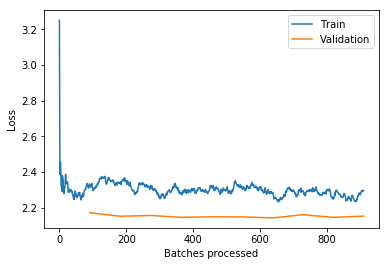

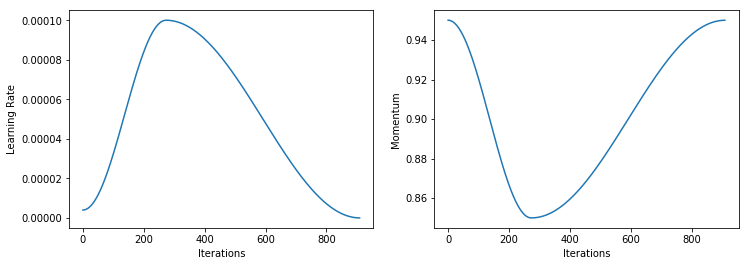

In [69]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 2.1

In [70]:
learn.load(save_path/f'{version}-s1.2-best');

In [71]:
if use_custom_model == False:
    learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


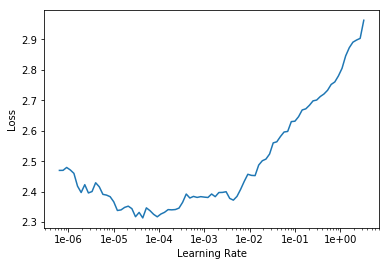

In [72]:
learn.lr_find()
learn.recorder.plot()

In [73]:
stage = 's2.1'
n_epochs = 10
max_lr = slice(1e-5)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,2.313726,2.162992,7.767826,2.162992,7.767826,2.162992,00:10
1,2.276243,2.155845,7.651116,2.155845,7.651116,2.155845,00:10
2,2.294108,2.143875,7.563678,2.143875,7.563678,2.143875,00:10
3,2.314861,2.146102,7.632334,2.146102,7.632334,2.146102,00:10
4,2.269788,2.152299,7.483915,2.152299,7.483915,2.152299,00:10
5,2.301528,2.141797,7.458492,2.141797,7.458492,2.141797,00:10
6,2.243052,2.147241,7.478500,2.147241,7.478500,2.147241,00:10
7,2.261799,2.155997,7.641103,2.155996,7.641103,2.155996,00:10
8,2.279555,2.149766,7.643700,2.149766,7.643700,2.149766,00:10
9,2.226674,2.147957,7.376783,2.147957,7.376783,2.147957,00:10


Better model found at epoch 0 with mean_absolute_error value: 2.162992238998413.
Better model found at epoch 1 with mean_absolute_error value: 2.1558451652526855.
Better model found at epoch 2 with mean_absolute_error value: 2.1438751220703125.
Better model found at epoch 5 with mean_absolute_error value: 2.1417970657348633.


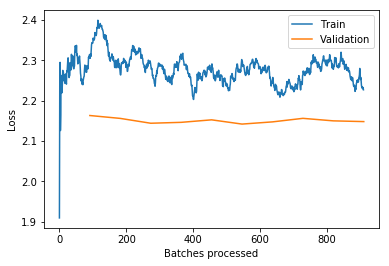

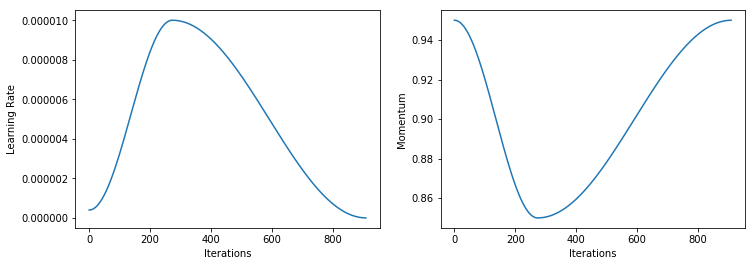

In [74]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

#### Stage 2.2

In [46]:
learn.load(save_path/f'{version}-s2.1-best');

In [47]:
if use_custom_model == False:
    learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


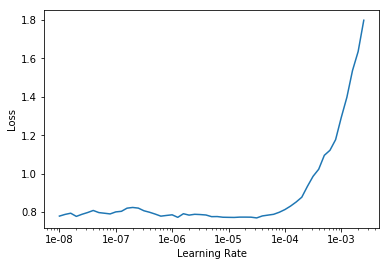

In [48]:
learn.lr_find(start_lr=1e-9)
learn.recorder.plot()

In [49]:
stage = 's2.2'
n_epochs = 10
max_lr = slice(4e-6)

epoch,train_loss,valid_loss,mean_squared_error,mean_absolute_error,mse_scaled,mae_scaled,time
0,0.789978,2.385329,9.099360,2.385329,9.099360,2.385329,00:10
1,0.759259,2.379320,9.084115,2.379320,9.084115,2.379320,00:10
2,0.722670,2.386216,9.157419,2.386216,9.157419,2.386216,00:10
3,0.746414,2.378181,9.058422,2.378181,9.058422,2.378181,00:10
4,0.739282,2.381790,9.132304,2.381789,9.132304,2.381789,00:09
5,0.716437,2.378356,9.102985,2.378356,9.102985,2.378356,00:10
6,0.715338,2.380627,9.087314,2.380627,9.087314,2.380627,00:10
7,0.704634,2.394674,9.138119,2.394674,9.138119,2.394674,00:10
8,0.687936,2.372939,9.082474,2.372939,9.082474,2.372939,00:10
9,0.690123,2.378623,9.056335,2.378624,9.056335,2.378624,00:10


Better model found at epoch 0 with mean_absolute_error value: 2.385328769683838.
Better model found at epoch 1 with mean_absolute_error value: 2.3793203830718994.
Better model found at epoch 3 with mean_absolute_error value: 2.378181219100952.
Better model found at epoch 8 with mean_absolute_error value: 2.372938871383667.


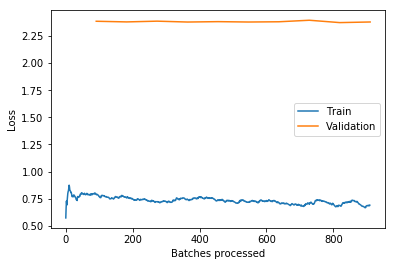

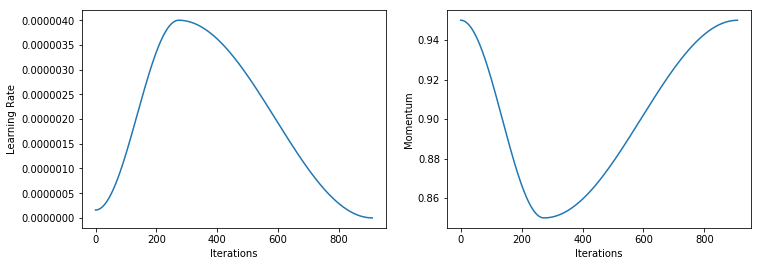

In [50]:
fit_one_cycle(learn, stage, n_epochs, max_lr)

## RESULTS

In [ ]:
learn.load(save_path/f'{version}-s2.1-best');

In [ ]:
# plot histograms of results
def plot_results(dataset):
    preds, targs = learn.get_preds(ds_type=dataset)
    preds = preds * scale
    targs = targs * scale
    print('min/max pred: ', min(preds).item(), max(preds).item())
    print('min/max targ: ', min(targs).item(), max(targs).item())
    fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))
    ax1.hist(preds.squeeze(), bins=50); ax1.set_xlabel('TTF'); ax1.set_ylabel('preds')
    ax2.plot(preds); ax2.set_xlabel('segment')
    ax3.hist(targs, bins=50); ax3.set_xlabel('TTF'); ax3.set_ylabel('targs')
    ax4.plot(targs); ax4.set_xlabel('segment')

#### Training Set

In [ ]:
plot_results(DatasetType.Fix)

#### Validation Set

In [ ]:
plot_results(DatasetType.Valid)

#### Test Set

In [ ]:
plot_results(DatasetType.Test)

## SUBMISSION

In [ ]:
test_preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [ ]:
# assume order of test set is unchanged
submission['time_to_failure'] = [test_preds[i].item() * scale for i in range(len(test_preds))]

In [ ]:
submission.head()

In [ ]:
submission_file = path/f'{version}-submission.csv'
submission.to_csv(submission_file)

In [ ]:
# submit to leaderboard
#! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f $submission_file -m "Message"